# Telecom Customer Churn

This data is taken from [kaggle](https://www.kaggle.com/blastchar/telco-customer-churn) and contains various telecom customer information. My goal is to predict the behaviour of customers in terms of churning by analyzing the relevant customer data. This is a binary classification task, which I will use NN's and SVM to accomplish the task.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import tensorflow
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV 

## Data Exploration

In [2]:
orig_df = pd.read_csv("telecom_churn.csv")
orig_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
print("The shape of the dataset is:", orig_df.shape)

The shape of the dataset is: (7043, 21)


Checking for null values and data types:

In [4]:
orig_df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Data Cleaning

Since 'customerID' is just an unique identifier for the customer and is not indictative of churn, I will drop it. I will also change each feature to their respective types, i.e categorical or numerical. 'TotalCharges' has empty string values, so I will replace it with the mean of 'TotalCharges'.

In [6]:
orig_df.drop('customerID', axis = 1, inplace=True)
orig_df['TotalCharges'] = orig_df['TotalCharges'].replace(' ', 0)

cat_cols = orig_df.drop(['tenure', 'MonthlyCharges', 'TotalCharges'], axis=1).columns
cont_cols = ['tenure', 'MonthlyCharges', 'TotalCharges'] 

orig_df[cat_cols] = orig_df[cat_cols].astype('category')
orig_df[cont_cols] = orig_df[cont_cols].apply(pd.to_numeric)

orig_df['TotalCharges'] = orig_df['TotalCharges'].replace(0, orig_df['TotalCharges'].mean())

## Data visualization

To understand the distribution of each feature, I will plot count bars for each feature, seperated by churn for categorical features. For continous features, I will plot boxplots seperated by churn.

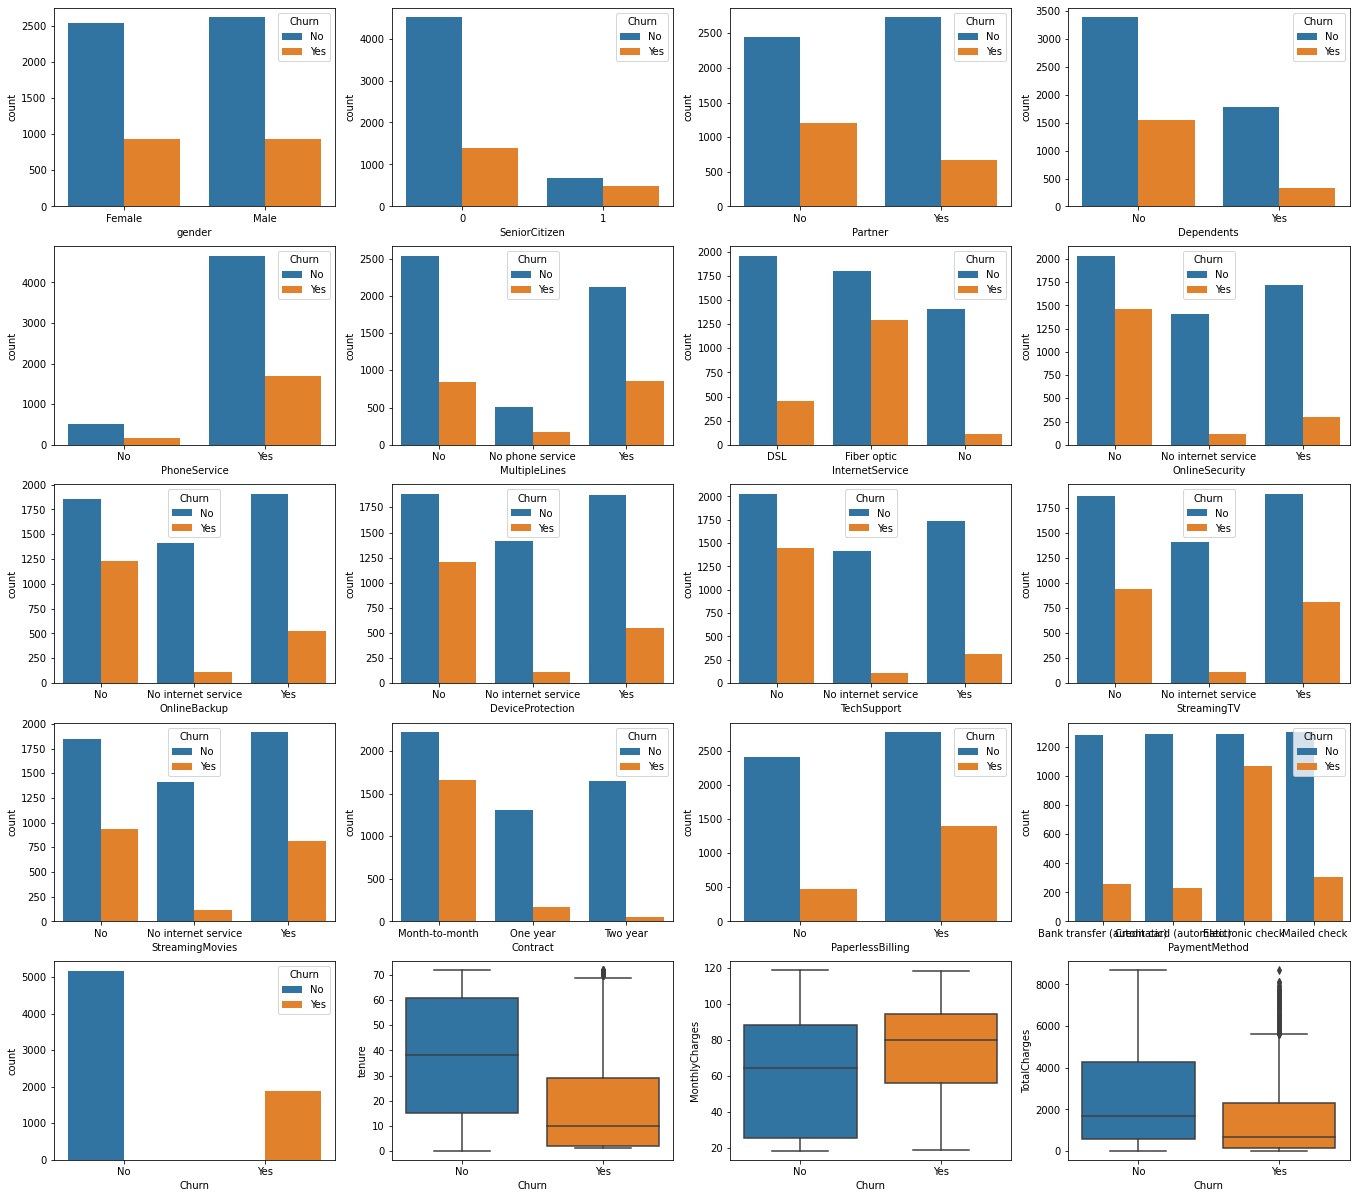

In [7]:
width = 4
height = 5

fig, ax = plt.subplots(height, width)
fig.subplots_adjust(bottom = 0, top = height - 1, 
                    left = 0, right = width - 1 )

n = 0
m = 0
for col in cat_cols:
  fig = sns.countplot(x=orig_df[col], hue= orig_df["Churn"], ax = ax[n][m])
  if m == width - 1:
    m = 0
    n += 1
  else:
    m += 1

for col in cont_cols:
  fig = sns.boxplot(y=orig_df[col], x=orig_df['Churn'], ax = ax[n][m])
  if m == width - 1:
    m = 0
    n += 1
  else:
    m += 1

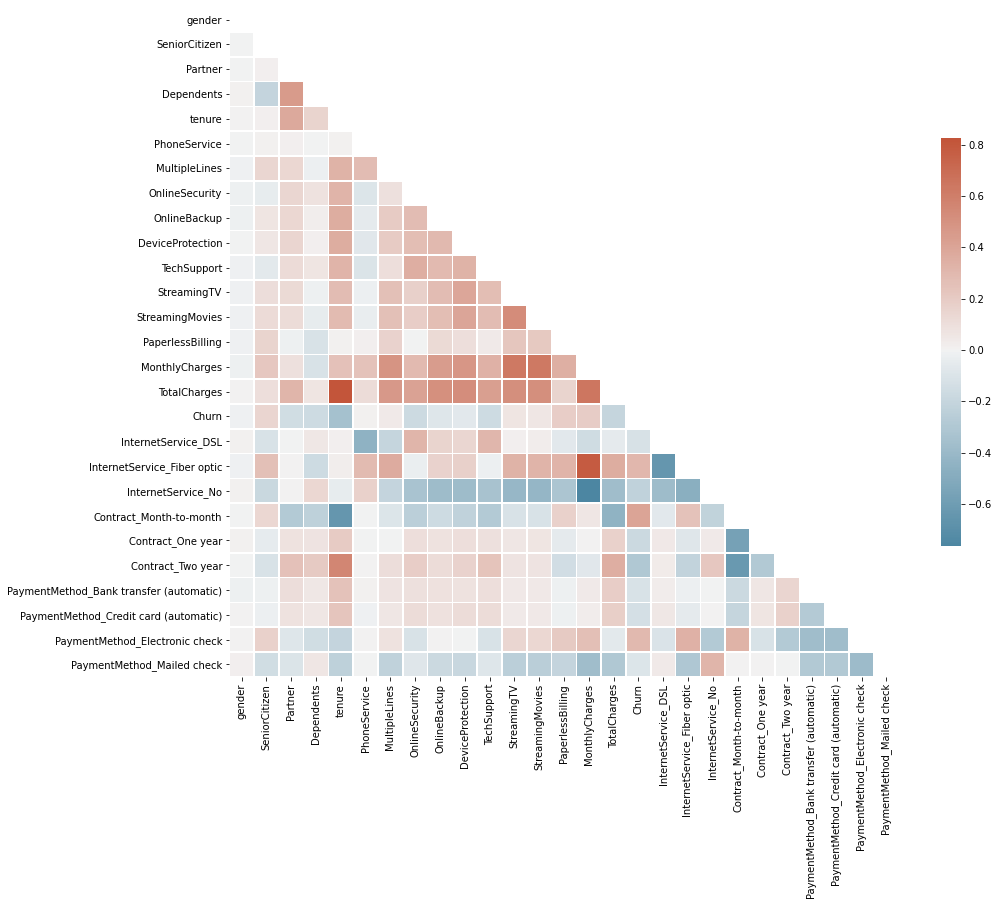

In [23]:
corr = orig_df.corr()
fig, ax = plt.subplots(figsize=(15, 15))
mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

From this correlation chart, it is clear that TotalCharges and tenure are highly correlated, which makes sense given that a customer that stays longer is more likely to pay more in total. We also can observe that having fiber optic internet service correpsonds to higher monthly charges, while having no internet at all lowers the monthly charges.

## Feature Preprocessing

For categorical variables with binary categories, I will encodes it as 0 or 1. Some feature like 'OnlineSecurity' have values like No, Yes and No internet service. Rather than one-hot encoding these features, I will categorize No internet service as no. This is because significantly extra dimensionality would be introduced if I didn't do so, which would hurt the model performance, especially with the low amount of data we have.

In [9]:
change_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
        'TechSupport', 'StreamingTV', 'StreamingMovies']

orig_df[change_cols] = orig_df[change_cols].replace('No internet service', 'No')
orig_df['MultipleLines'] = orig_df['MultipleLines'].replace('No phone service', 'No')


bin_cat_cols = ['MultipleLines', 'gender', 'SeniorCitizen', 'Partner', 
                'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn'] + change_cols

orig_df[bin_cat_cols] = orig_df[bin_cat_cols].apply(lambda x: x.cat.codes)


For categorical variables with 3 or more categories, I will one hot encode them.

In [10]:
multi_cat_cols = ['InternetService', 'Contract', 'PaymentMethod']
orig_df = pd.get_dummies(orig_df, columns=multi_cat_cols)

For the continuous variables, I will normalize them.

In [11]:
continuous_cols = orig_df[cont_cols]
orig_df[cont_cols] = (continuous_cols - continuous_cols.mean())/continuous_cols.std()

The new shape of the dataset is:

In [12]:
print("The shape of the dataset is", orig_df.shape)

The shape of the dataset is (7043, 27)


In [13]:
X = orig_df.drop(['Churn'], axis = 1)
Y = orig_df['Churn']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

print("The shape of X_train is:", X_train.shape)
print("The shape of Y_train is:", Y_train.shape)
print("The shape of X_test is:", X_test.shape)
print("The shape of Y_test is:", Y_test.shape)

The shape of X_train is: (5634, 26)
The shape of Y_train is: (5634,)
The shape of X_test is: (1409, 26)
The shape of Y_test is: (1409,)


## Neural Network

For this problem, I will be using a fully connected, 5 hidden layer neural network. The specific architecture are as follows:

- First layer: 64 units, relu activation
- Second layer: 32 units, relu activation
- Third layer: 16 units, relu activation
- Fourth layer: 8 units, relu activation
- Fifth layer: 1 unit, sigmoid activation

I will be using adam optimizer, with loss binary cross entropy. The class 'Churn' will also be weighted to account for the extra 

In [14]:
nn_model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
])

In [15]:
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

In [16]:
nn_model.fit(X_train, Y_train, class_weight= {0:1, 1:3}, epochs = 100, batch_size=32)

Epoch 1/100
177/177 [==============================] - 1s 2ms/step - loss: 0.9182 - accuracy: 0.5711 - auc: 0.8002
Epoch 2/100
177/177 [==============================] - 0s 2ms/step - loss: 0.7242 - accuracy: 0.7553 - auc: 0.8542
Epoch 3/100
177/177 [==============================] - 0s 2ms/step - loss: 0.7274 - accuracy: 0.7523 - auc: 0.8499
Epoch 4/100
177/177 [==============================] - 0s 2ms/step - loss: 0.7132 - accuracy: 0.7563 - auc: 0.8583
Epoch 5/100
177/177 [==============================] - 0s 2ms/step - loss: 0.7135 - accuracy: 0.7556 - auc: 0.8594
Epoch 6/100
177/177 [==============================] - 0s 2ms/step - loss: 0.7159 - accuracy: 0.7579 - auc: 0.8550
Epoch 7/100
177/177 [==============================] - 0s 2ms/step - loss: 0.7083 - accuracy: 0.7611 - auc: 0.8582
Epoch 8/100
177/177 [==============================] - 0s 2ms/step - loss: 0.7255 - accuracy: 0.7447 - auc: 0.8543
Epoch 9/100
177/177 [==============================] - 0s 2ms/step - loss: 0.711

In [17]:
nn_model.evaluate(X_test, Y_test)[0]

45/45 [==============================] - 0s 1ms/step - loss: 1.1538 - accuracy: 0.7204 - auc: 0.7498


1.1538143157958984

## Support Vector Machine

The next algorithm I will test is the support vector machine. I will begin by creating a baseline model, with the default hyperparameters set by sklearn. 

In [18]:
svm_model = SVC()
svm_model.fit(X_train, Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [19]:
Y_pred = svm_model.predict(X_test)

svm_accuracy = accuracy_score(Y_test, Y_pred)
svm_roc = roc_auc_score(Y_test, Y_pred)

print("baseline support vector machine accuracy:", svm_accuracy)
print("baseline support vector machine roc score:", svm_roc)

baseline support vector machine accuracy: 0.7963094393186657
baseline support vector machine roc score: 0.7067369864294284


These metrics provide a base on which we can improve upon. In order to get better results, I will test out various hyperparameters by performing a grid search.

In [20]:
param_grid = {'C': [0.1, 1, 10, 100],  
              'gamma': [1, 0.1, 0.01, 0.001], 
              'kernel': ['rbf', 'sigmoid', 'linear'],
              'class_weight': ['balanced']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True)   
grid.fit(X_train, Y_train) 

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'class_weight': ['balanced'],
                         'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'sigmoid', 'linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

The following parameters had the best results:

In [21]:
print(grid.best_params_) 

{'C': 0.1, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}


In [22]:
grid_predictions = grid.predict(X_test) 
  
svm_accuracy = accuracy_score(Y_test, grid_predictions)
svm_roc = roc_auc_score(Y_test, grid_predictions)

print("support vector machine accuracy:", svm_accuracy)
print("support vector machine roc:", svm_roc)

support vector machine accuracy: 0.7835344215755855
support vector machine roc: 0.6911383595863909
